# Data and visualizations

> Exploring the 🤗 dataset API and writing some convenience functions for viz

Adapted from:

- [https://youtu.be/veqj0DsZSXU?si=TIBU6N98yZhR9PrG&t=3674](https://youtu.be/veqj0DsZSXU?si=TIBU6N98yZhR9PrG&t=3674)

This is, again, a topic I already know a lot about so I'm going through this notebook as quickly as possible.

In [1]:
#| default_exp datasets

In [2]:
# |export
import math
from itertools import zip_longest
from typing import Optional

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as T
from datasets import load_dataset
from torch.utils.data import DataLoader

## Huggingface Datasets

In [3]:
dsd = load_dataset("fashion_mnist")
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
x, y = dsd.column_names["train"]
x, y

('image', 'label')

In [5]:
trn = dsd["train"]
example = trn[0]
xb = example[x]
yb = example[y]
xb

In [6]:
y_feats = trn.features[y]
y_feats.int2str(example[y])

'Ankle boot'

In [7]:
def collate_fn(b):
    return dict(
        x=torch.stack([T.to_tensor(example[x]) for example in b]),
        y=torch.tensor([example[y] for example in b]),
    )


dl = DataLoader(trn, collate_fn=collate_fn, batch_size=16)
out = next(iter(dl))
out["x"].shape, out["y"]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

This is the only tip I thought was interesting from the first hour. You can use this to avoid a `return`.

In [8]:
# |export
def inplace(f):
    def _f(b):
        f(b)
        return b

    return _f

In [9]:
@inplace
def transformi(batch):
    batch["image"] = [T.to_tensor(example) for example in batch["image"]]


t_trn = trn.with_transform(transformi)
t_trn[0]["image"].shape, t_trn[0]["label"]

(torch.Size([1, 28, 28]), 9)

## Plotting

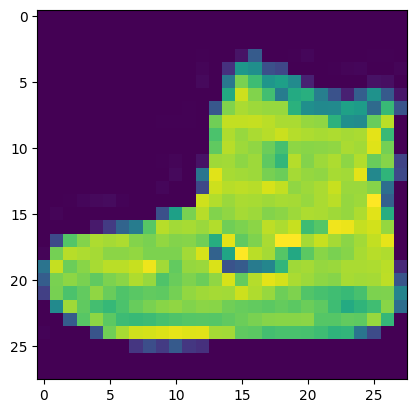

In [10]:
b = t_trn[0]
xb = b["image"]
plt.imshow(xb.squeeze())

We'll copy-and-paste some of the plotting convenience functions

In [11]:
# |export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs
):  # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax

`delegates` is a nice feature that creates the correct documentation for `kwargs`

In [12]:
subplots?

Signature:
subplots(
    nrows: int = 1,
    ncols: int = 1,
    figsize: tuple = None,
    imsize: int = 3,
    suptitle: str = None,
    *,
    sharex: "bool | Literal['none', 'all', 'row', 'col']" = False,
    sharey: "bool | Literal['none', 'all', 'row', 'col']" = False,
    squeeze: 'bool' = True,
    width_ratios: 'Sequence[float] | None' = None,
    height_ratios: 'Sequence[float] | None' = None,
    subplot_kw: 'dict[str, Any] | None' = None,
    gridspec_kw: 'dict[str, Any] | None' = None,
    **kwargs,
)
Docstring: A figure and set of subplots to display images of `imsize` inches
File:      /tmp/ipykernel_22296/3433216597.py
Type:      function

I'm straight up just stealing these from the FastAI notebooks 😈

In [13]:
# |export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs,
):  # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax


@fc.delegates(subplots)
def get_grid(
    n: int,  # Number of axes
    nrows: int = None,  # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols: int = None,  # Number of columns, defaulting to `ceil(n/rows)`
    title: str = None,  # If passed, title set to the figure
    weight: str = "bold",  # Title font weight
    size: int = 14,  # Title font size
    **kwargs,
):  # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.floor(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n / nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows * ncols):
        axs.flat[i].set_axis_off()
    if title is not None:
        fig.suptitle(title, weight=weight, size=size)
    return fig, axs


@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ("cpu", "permute", "detach")):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5:
            im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1] == 1:
        im = im[..., 0]
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe:
        ax.axis("off")
    return ax


@fc.delegates(subplots)
def show_images(
    ims: list,  # Images to show
    nrows: Optional[int] = None,  # Number of rows in grid
    ncols: Optional[int] = None,  # Number of columns in grid (auto-calculated if None)
    titles: Optional[list] = None,  # Optional list of titles for each image
    **kwargs,
):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

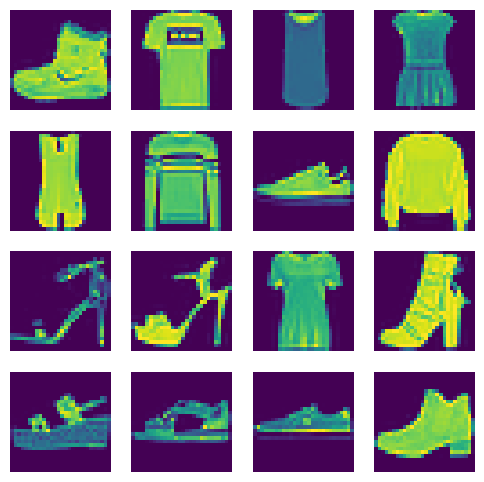

In [14]:
b = t_trn[:16]
show_images(b["image"], figsize=(6, 6))

In [15]:
#| hide
import nbdev

nbdev.nbdev_export()